## Is it a mustache?

### Download training images from duckduckgo

In [3]:
!pip install -Uqq duckduckgo_search

In [11]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


In [12]:
mustache_img_urls = search_images('mustache photos', max_images=1)
mustache_img_urls[0]

'https://cdn.psychologytoday.com/sites/default/files/field_blog_entry_images/2017-09/shutterstock_121336534.jpg'

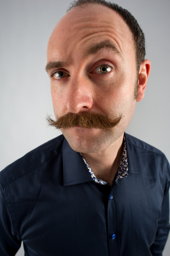

In [13]:
from fastdownload import download_url
dest = 'mustache.jpg'
download_url(mustache_img_urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

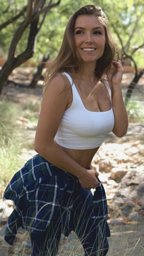

In [14]:
download_url(search_images('woman photos', max_images=1)[0], 'woman.jpg', show_progress=False)
Image.open('woman.jpg').to_thumb(256,256)

In [15]:
searches = ['mustache', 'woman']
path = Path('images')
from time import sleep

for term in searches:
    dest = (path/term)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{term} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{term} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{term} shade photo'))
    sleep(10)
    resize_images(path/term, max_size=400, dest=dest)

### Train the mustache model

Cleanup bad images.

In [16]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

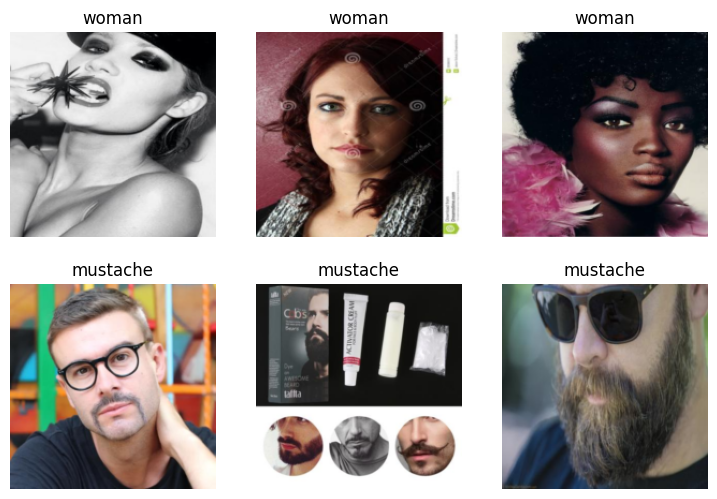

In [17]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [18]:
import warnings
warnings.filterwarnings('ignore')


learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.726559,0.264994,0.082609,00:52


epoch,train_loss,valid_loss,error_rate,time
0,0.221511,0.277716,0.082609,01:17
1,0.129023,0.236277,0.052174,00:52
2,0.087648,0.235697,0.065217,01:01


### Test out the model

Let's see what our model thinks about that mustache photo we downloaded at the start:

This is a: mustache.
Probability it's a mustache: 1.0000


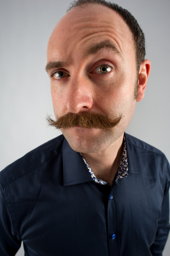

In [24]:
is_mustache,_,probs = learn.predict(PILImage.create('mustache.jpg'))

print(f"This is a: {is_mustache}.")
print(f"Probability it's a mustache: {probs[0]:.4f}")

im = Image.open('mustache.jpg')
im.to_thumb(256,256)


This is a: woman.
Probability it's a mustache: 0.0000


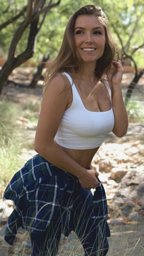

In [25]:
is_mustache,_,probs = learn.predict(PILImage.create('woman.jpg'))

print(f"This is a: {is_mustache}.")
print(f"Probability it's a mustache: {probs[0]:.4f}")

im = Image.open('woman.jpg')
im.to_thumb(256,256)
